# Project 2: Topic Classification

In this project, you'll work with text data from newsgroup postings on a variety of topics. You'll train classifiers to distinguish between the topics based on the text of the posts. Whereas with digit classification, the input is relatively dense: a 28x28 matrix of pixels, many of which are non-zero, here we'll represent each document with a "bag-of-words" model. As you'll see, this makes the feature representation quite sparse -- only a few words of the total vocabulary are active in any given document. The bag-of-words assumption here is that the label depends only on the words; their order is not important.

The SK-learn documentation on feature extraction will prove useful:
http://scikit-learn.org/stable/modules/feature_extraction.html

Each problem can be addressed succinctly with the included packages -- please don't add any more. Grading will be based on writing clean, commented code, along with a few short answers.

As always, you're welcome to work on the project in groups and discuss ideas on the course wall, but please prepare your own write-up and write your own code.

In [6]:
# This tells matplotlib not to try opening a new window for each plot.
%matplotlib inline

# General libraries.
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# SK-learn libraries for learning.
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.grid_search import GridSearchCV

# SK-learn libraries for evaluation.
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import classification_report

# SK-learn library for importing the newsgroup data.
from sklearn.datasets import fetch_20newsgroups

# SK-learn libraries for feature extraction from text.
from sklearn.feature_extraction.text import *

C:\Users\mgruz\Anaconda2\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
C:\Users\mgruz\Anaconda2\lib\site-packages\sklearn\grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


Load the data, stripping out metadata so that we learn classifiers that only use textual features. By default, newsgroups data is split into train and test sets. We further split the test so we have a dev set. Note that we specify 4 categories to use for this project. If you remove the categories argument from the fetch function, you'll get all 20 categories.

In [7]:
categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
newsgroups_train = fetch_20newsgroups(subset='train',
                                      remove=('headers', 'footers', 'quotes'),
                                      categories=categories)
newsgroups_test = fetch_20newsgroups(subset='test',
                                     remove=('headers', 'footers', 'quotes'),
                                     categories=categories)

num_test = len(newsgroups_test.target)
test_data, test_labels = newsgroups_test.data[num_test/2:], newsgroups_test.target[num_test/2:]
dev_data, dev_labels = newsgroups_test.data[:num_test/2], newsgroups_test.target[:num_test/2]
train_data, train_labels = newsgroups_train.data, newsgroups_train.target

print 'training label shape:', train_labels.shape
print 'test label shape:', test_labels.shape
print 'dev label shape:', dev_labels.shape
print 'labels names:', newsgroups_train.target_names

training label shape: (2034L,)
test label shape: (677L,)
dev label shape: (676L,)
labels names: ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']


In [23]:
newsgroups_train.target_names

['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']

(1) For each of the first 5 training examples, print the text of the message along with the label.

In [8]:
def P1(num_examples=5):

    ### STUDENT START ###
    # // loop through number of examples needed for question (5), which is hardcoded with num_examples=5 in def P1() above
    for i in range(num_examples):
        # // read the ith example (0 to 4) for a total of five examples, python starts at 0 for index so i+1 is needed for 
        # // document number
        print "***** Example #{} - Type = {} *****".format(i + 1, categories[train_labels[i]])
        print "\n"
        print train_data[i]
        print "\n"
        print "***** END Example {} *****".format(i + 1)
        print "\n"
        print "\n"
    ### STUDENT END ###
    
    
# // run def: P1()
# // Input : num_examples = how many different examples to print (currently hardcoded at 5)
# // Output: String print of block text from fetch_20newsgroups() in sklearn.datasets module
P1()

***** Example #1 - Type = comp.graphics *****


Hi,

I've noticed that if you only save a model (with all your mapping planes
positioned carefully) to a .3DS file that when you reload it after restarting
3DS, they are given a default position and orientation.  But if you save
to a .PRJ file their positions/orientation are preserved.  Does anyone
know why this information is not stored in the .3DS file?  Nothing is
explicitly said in the manual about saving texture rules in the .PRJ file. 
I'd like to be able to read the texture rule information, does anyone have 
the format for the .PRJ file?

Is the .CEL file format available from somewhere?

Rych


***** END Example 1 *****




***** Example #2 - Type = talk.religion.misc *****




Seems to be, barring evidence to the contrary, that Koresh was simply
another deranged fanatic who thought it neccessary to take a whole bunch of
folks with him, children and all, to satisfy his delusional mania. Jim
Jones, circa 1993.


Nope - fruitcakes 

(2) Use CountVectorizer to turn the raw training text into feature vectors. You should use the fit_transform function, which makes 2 passes through the data: first it computes the vocabulary ("fit"), second it converts the raw text into feature vectors using the vocabulary ("transform").

The vectorizer has a lot of options. To get familiar with some of them, write code to answer these questions:

a. The output of the transform (also of fit_transform) is a sparse matrix: http://docs.scipy.org/doc/scipy-0.14.0/reference/generated/scipy.sparse.csr_matrix.html. What is the size of the vocabulary? What is the average number of non-zero features per example? What fraction of the entries in the matrix are non-zero? Hint: use "nnz" and "shape" attributes.

b. What are the 0th and last feature strings (in alphabetical order)? Hint: use the vectorizer's get_feature_names function.

c. Specify your own vocabulary with 4 words: ["atheism", "graphics", "space", "religion"]. Confirm the training vectors are appropriately shaped. Now what's the average number of non-zero features per example?

d. Instead of extracting unigram word features, use "analyzer" and "ngram_range" to extract bigram and trigram character features. What size vocabulary does this yield?

e. Use the "min_df" argument to prune words that appear in fewer than 10 documents. What size vocabulary does this yield?

f. Using the standard CountVectorizer, what fraction of the words in the dev data are missing from the vocabulary? Hint: build a vocabulary for both train and dev and look at the size of the difference.

In [9]:
def P2():

    ### STUDENT START ###
    # // instantiate the CountVectorizer() which converts a collection of text documents to a matrix of token counts
    vectorizer = CountVectorizer()
    # // need to learn the vocabulary dictionary and return term-document matrix for fitted information
    fit_data = vectorizer.fit_transform(train_data)
    
    # 2a.   
    # // .shape is a NxM length response. shape[0] = how many examples are in the data set used for the fit_transform
    # //.shape[1] will return with the total number of unique vocabulary in the fitted data
    vocabulary_size = fit_data.shape[1]
    # // .nnz will count the number of non zero per example and then divide by number of examples to get the average
    # // amount of non zeros
    avg_number_non_zero = float(fit_data.nnz)/float(fit_data.shape[0])
    # // to get the total fraction need to find the amount non zero (.nnz) and divid it by the area of the matrix 
    # // (.shape[0]*.shape[1])
    fraction_non_zero_elements = float(fit_data.nnz)/float(fit_data.shape[0] * fit_data.shape[1]) * 100
    
    # 2b
    # // use method CountVectorizer() class to array mapping from feature integer indices to feature name
    sorted_feature_names = sorted(vectorizer.get_feature_names())
    # // sort by name ascending order and grab first item
    zeroth_feature_string = sorted_feature_names[0]
    # // sort by name ascending order and grab last item
    last_feature_string = sorted_feature_names[-1]
    
    # 2c
    # // instantiate a "pretty" string list for specific vocabulary results
    my_vocab_list = ["atheism", "graphics", "space", "religion"]
    # // converts a collection of text documents to a matrix of token counts with vocabulary list in raw text
    my_vectorizer = CountVectorizer(vocabulary=my_vocab_list)
    # // need to learn the vocabulary dictionary and return term-document matrix for fitted information
    my_fit_data = my_vectorizer.fit_transform(train_data)
    # // converts a collection of text documents to a matrix of token counts with vocabulary list in raw text
    my_avg_number_non_zero = float(my_fit_data.nnz)/float(my_fit_data.shape[0]) * 100
    # // get the overall dimensions of the data (checking if it is appropriately sized)
    my_fit_shape = my_fit_data.shape
    
    # 2d
    # // converts a collection of text documents to a matrix of token counts with vocabulary that is only 2 to 3 
    # // strings characters long
    analyzer = CountVectorizer(analyzer='char', ngram_range=(2, 3))
    # // need to learn the vocabulary dictionary and return term-document matrix for fitted information
    fit_analyzer = analyzer.fit_transform(train_data)
    # // similar explanation in 2a
    n_gram_vocabulary_size = fit_analyzer.shape[1]
    
    # 2e
    # // converts a collection of text documents to a matrix of token counts with words that have appered in fewer
    # // than ten documents
    prune = CountVectorizer(min_df=10)
    # // need to learn the vocabulary dictionary and return term-document matrix for fitted information
    fit_prune = prune.fit_transform(train_data)
    # similar explanation in 2a
    prune_vocabulary_size = fit_prune.shape[1]
    
    # 2f
    # // instantiate the CountVectorizer() which converts a collection of text documents to a matrix of token counts
    word_check_train = CountVectorizer()
    # // need to learn the vocabulary dictionary and return term-document matrix for fitted information
    word_check_train.fit_transform(train_data)
    # similar in 2b
    train_word_list = word_check_train.get_feature_names()
    # // do same for the dev data set
    word_check_dev = CountVectorizer()
    # // fit dev dataset to see what fraction of the words in the dev data are missing from the vocabulary
    word_check_dev.fit_transform(dev_data)
    # similar in 2b
    dev_word_list = word_check_dev.get_feature_names()
    # // instantiate a count variable to count dev data are missing from the vocabulary
    amount_dev_data_not_in_train_data = 0
    # // loop through dev list and check if it exists in the training vocab list
    for word in dev_word_list:
        if word not in train_word_list:
            amount_dev_data_not_in_train_data += 1
    # // divide total dev count not in training count by the amount in dev list to get percentage not in training set (*100)
    fraction_dev_not_in_train_elements = float(amount_dev_data_not_in_train_data) / float(len(dev_word_list)) * 100
        
    # print statements for question 2
    print "***** QUESTION 2a - START *****"
    print "The size of the vocabulary is: {}".format(vocabulary_size)
    print "The average number of non-zero features per example: {}".format(round(avg_number_non_zero, 3))
    print "The fraction of the entries in the matrix that are non-zero is: {} %".format(round(fraction_non_zero_elements, 3))
    print "***** QUESTION 2a - END *****"
    print "\n"
    print "***** QUESTION 2b - START *****"
    print "The 0th feature string is: {} and the last feature string is: {}".format(zeroth_feature_string, last_feature_string)
    print "***** QUESTION 2b - END *****"
    print "\n"
    print "***** QUESTION 2c - START *****"
    print "The shape of the new data with specific vocabulary list is: {} %".format(my_fit_shape)
    print "The average number of non-zero features per example with my vocabulary is : {} %".format(round(my_avg_number_non_zero, 3))
    print "***** QUESTION 2c - END *****"
    print "\n"
    print "***** QUESTION 2d - START *****"
    print "The size of the vocabulary for only bigram and trigram words is : {}".format(n_gram_vocabulary_size)
    print "***** QUESTION 2d - END *****"
    print "\n"
    print "***** QUESTION 2e - START *****"
    print "The size of the vocabulary for vocabulary appearing in at least 10 documents is : {}".format(prune_vocabulary_size)
    print "***** QUESTION 2e - END *****"
    print "\n"
    print "***** QUESTION 2f - START *****"
    print "The fraction of the dev data strings not in training data: {} %".format(round(fraction_dev_not_in_train_elements, 3))
    print "***** QUESTION 2f - END *****"
    print "\n"
    ### STUDENT END ###
    
# // run def: P2()
# // Input : nothing
# // Output: String print of block text from to answer the prompts 2a to 2f
P2()

***** QUESTION 2a - START *****
The size of the vocabulary is: 26879
The average number of non-zero features per example: 96.706
The fraction of the entries in the matrix that are non-zero is: 0.36 %
***** QUESTION 2a - END *****


***** QUESTION 2b - START *****
The 0th feature string is: 00 and the last feature string is: zyxel
***** QUESTION 2b - END *****


***** QUESTION 2c - START *****
The shape of the new data with specific vocabulary list is: (2034, 4) %
The average number of non-zero features per example with my vocabulary is : 26.844 %
***** QUESTION 2c - END *****


***** QUESTION 2d - START *****
The size of the vocabulary for only bigram and trigram words is : 35478
***** QUESTION 2d - END *****


***** QUESTION 2e - START *****
The size of the vocabulary for vocabulary appearing in at least 10 documents is : 3064
***** QUESTION 2e - END *****


***** QUESTION 2f - START *****
The fraction of the dev data strings not in training data: 24.788 %
***** QUESTION 2f - END ****

(3) Use the default CountVectorizer options and report the f1 score (use metrics.f1_score) for a k nearest neighbors classifier; find the optimal value for k. Also fit a Multinomial Naive Bayes model and find the optimal value for alpha. Finally, fit a logistic regression model and find the optimal value for the regularization strength C using l2 regularization. A few questions:

a. Why doesn't nearest neighbors work well for this problem?

b. Any ideas why logistic regression doesn't work as well as Naive Bayes?

c. Logistic regression estimates a weight vector for each class, which you can access with the coef\_ attribute. Output the sum of the squared weight values for each class for each setting of the C parameter. Briefly explain the relationship between the sum and the value of C.

The best parameter for the knn model prediction is for this data set is: {'n_neighbors': 59}
The best alpha parameter for the multinomial naives bayes model for this data set is: {'alpha': 0.0042100000000000002}


C:\Users\mgruz\Anaconda2\lib\site-packages\sklearn\metrics\classification.py:1113: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


The best C parameter for the logistic regression model for this data set is: {'C': 0.2}


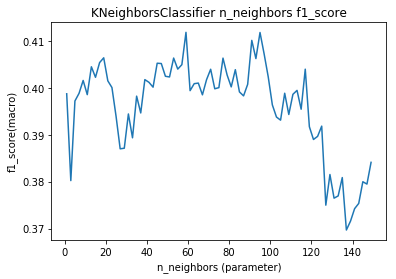

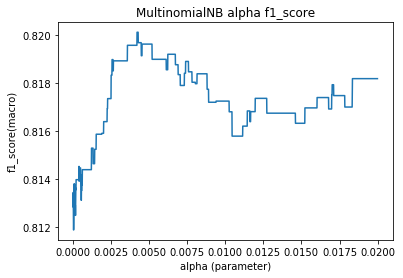

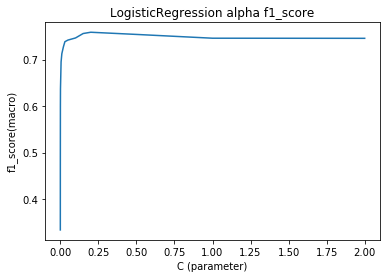

In [10]:
def P3():
    ### STUDENT START ###
    
    # // look at question 2 comments for eplanation
    vectorizer = CountVectorizer()
    fit_vectorizer = vectorizer.fit_transform(train_data)
    # // instantiate a list to loop through parameter values to find optimal parameter value
    knn_param_list = np.arange(1, 150, 2)
    # // instantiate a KNeighborsClassifier to GridSearchCV for best parameters (n_neighbors)
    knn = KNeighborsClassifier()
    grid_search_knn = GridSearchCV(knn, {'n_neighbors': knn_param_list}, scoring='f1_macro')
    # // fit the vecotrized data to the KNeighborsClassifier
    grid_search_knn.fit(fit_vectorizer, train_labels)
    # // loop through each score to grab the score to plot for graph explaining the hyoer-parameter plot
    # // using f1_macro score to decide optimal parameter ()
    knn_k_value_list = []
    knn_f_score_mean_list = []
    for data in grid_search_knn.grid_scores_:
        knn_k_value_list.append(data.parameters['n_neighbors'])
        knn_f_score_mean_list.append(data.mean_validation_score)
    # // instantiate a plot
    fig = plt.figure()
    plt.plot(knn_k_value_list, knn_f_score_mean_list)
    plt.title('KNeighborsClassifier n_neighbors f1_score')
    plt.xlabel('n_neighbors (parameter)')
    plt.ylabel('f1_score(macro)')
    # // print the best parameter with the best_params_ method
    knn_best_param = grid_search_knn.best_params_
    print "The best parameter for the knn model prediction is for this data set is: {}".format(knn_best_param)
    
    # // instantiate a list to loop through parameter values to find optimal parameter value
    nb_param_list = np.arange(0.00001, 0.02, .00001)
    # // instantiate a MultinomialNB to GridSearchCV for best parameters (alpha)
    mnb = MultinomialNB()
    grid_search_mnb = GridSearchCV(mnb, {'alpha': nb_param_list}, scoring='f1_macro')
    # // fit the vecotrized data to the MultinomialNB
    grid_search_mnb.fit(fit_vectorizer, train_labels)
    # // loop through each score to grab the score to plot for graph explaining the hyoer-parameter plot
    # // using f1_macro score to decide optimal parameter ()
    mnb_alpha_value_list = []
    mnb_f_score_mean_list = []
    for data in grid_search_mnb.grid_scores_:
        mnb_alpha_value_list.append(data.parameters['alpha'])
        mnb_f_score_mean_list.append(data.mean_validation_score)
    # // instantiate a plot
    fig = plt.figure()
    plt.plot(mnb_alpha_value_list, mnb_f_score_mean_list)
    plt.title('MultinomialNB alpha f1_score')
    plt.xlabel('alpha (parameter)')
    plt.ylabel('f1_score(macro)')
    # // print the best parameter with the best_params_ method
    mnb_best_param = grid_search_mnb.best_params_
    print "The best alpha parameter for the multinomial naives bayes model for this data set is: {}".format(mnb_best_param)
    
    # // instantiate a list to loop through parameter values to find optimal parameter value
    logistic_reg_param_list = [0.00001, 0.0001, 0.0005, 0.001, .005, 0.01, 0.02, 0.03, 0.04,  0.05, 0.1,  0.15, 0.2, 
                     0.5,  1, 2]
    # // instantiate a LogisticRegression to GridSearchCV for best parameters (C) with penalty='l2'
    lr = LogisticRegression(penalty='l2')
    grid_search_lr = GridSearchCV(lr, {'C': logistic_reg_param_list}, scoring='f1_macro')
    # // fit the vecotrized data to the LogisticRegression
    grid_search_lr.fit(fit_vectorizer, train_labels)
    # // loop through each score to grab the score to plot for graph explaining the hyoer-parameter plot
    # // using f1_macro score to decide optimal parameter ()
    lr_c_value_list = []
    lr_f_score_mean_list = []
    for data in grid_search_lr.grid_scores_:
        lr_c_value_list.append(data.parameters['C'])
        lr_f_score_mean_list.append(data.mean_validation_score)
    # // instantiate a plot
    fig = plt.figure()
    plt.plot(lr_c_value_list, lr_f_score_mean_list)
    plt.title('LogisticRegression alpha f1_score')
    plt.xlabel('C (parameter)')
    plt.ylabel('f1_score(macro)')
    
    lr_best_param = grid_search_lr.best_params_
    print "The best C parameter for the logistic regression model for this data set is: {}".format(lr_best_param)

    ### STUDENT END ###
    
# // run def: P3()
# // Input : nothing
# // Output: String print of block text from to answer the prompts 3a to 3c
P3()

In [11]:
def P3_f1_scores():
    # // below functions just instantiates each individual class: CountVectorizer, KNeighborsClassifier, MultinomialNB,
    # // and LogisticRegression to feed in vectorized training for fitting and then test vectorized dev data for a test
    # // and prints out the f1_score for each variable
    
    vectorizer = CountVectorizer()
    fit_vectorizer = vectorizer.fit_transform(train_data)
    fit_vectorizer_dev = vectorizer.transform(dev_data)
    
    knn_f1 = KNeighborsClassifier(n_neighbors=59)
    knn_f1.fit(fit_vectorizer, train_labels)
    knn_f1_prediction = knn_f1.predict(fit_vectorizer_dev)
    knn_f1_metric = metrics.f1_score(dev_labels, knn_f1_prediction, average='micro') * 100

    mnb_f1 = MultinomialNB(alpha=0.0042100000000000002)
    mnb_f1.fit(fit_vectorizer, train_labels)
    mnb_f1_prediction = mnb_f1.predict(fit_vectorizer_dev)
    mnb_f1_metric = metrics.f1_score(dev_labels, mnb_f1_prediction, average='micro') * 100
    
    lr_f1 = LogisticRegression(penalty='l2', C=0.2)
    lr_f1.fit(fit_vectorizer, train_labels)
    lr_f1_prediction = lr_f1.predict(fit_vectorizer_dev)
    lr_f1_metric = metrics.f1_score(dev_labels, lr_f1_prediction, average='micro')  * 100
    
    print "The average (globally) f1 score for the KNeighborsClassifier model fit is: {} %".format(round(knn_f1_metric, 3))
    print "The average (globally) f1 score for the MultinomialNB model fit is: {} %".format(round(mnb_f1_metric, 3))
    print "The average (globally) f1 score for the LogisticRegression model fit is: {} %".format(round(lr_f1_metric, 3))

# // run def: P3_f1_scores()
# // Input : nothing
# // Output: String print of block text from to answer the prompts 3a to 3b specifically f1 data
P3_f1_scores()

The average (globally) f1 score for the KNeighborsClassifier model fit is: 43.935 %
The average (globally) f1 score for the MultinomialNB model fit is: 77.515 %
The average (globally) f1 score for the LogisticRegression model fit is: 71.302 %


QUESTION 3a: Why doesn't nearest neighbors work well for this problem?

ANSWER 3a: The KNN tries to make prediction based on how closly related or similar the test case is to the training case. For this data structure there is a lot of features that the KNN model needs to take into consideration when doing the distance calculations to the test data fit. We are also assigning the same weight to all features (highly dimension) in the model and each data case has a lot of feature so the fit gets muddied and the fit has a hard time differentiating the overall distance calculated for the KNN.

QUESTION 3b: Any ideas why logistic regression doesn't work as well as Naive Bayes?

ANSWER 3b: One of the biggest differences for MultinomialNB and LogisticRegression is that MultinomialNB assumes that the features in the data are independent and fits the weights independently. The LogisticRegression model does not do this and actually fits all the features together and minimized error together. The variance that hurts the regression from the data (overfitting) has a larger effect than the bias effects (underfitting) on the MultinomialNB.

  C                  alt.atheism          comp.graphics        sci.space            talk.religion.misc  
1e-05                0.0                  0.001                0.0                  0.0                 
0.0001               0.008                0.012                0.009                0.009               
0.0005               0.069                0.081                0.074                0.083               
0.001                0.165                0.201                0.181                0.187               
0.005                1.144                1.398                1.316                1.078               
0.01                 2.541                2.94                 2.862                2.25                
0.02                 5.471                5.876                5.941                4.668               
0.03                 8.398                8.619                8.926                7.097               
0.04                 11.27                11.206       

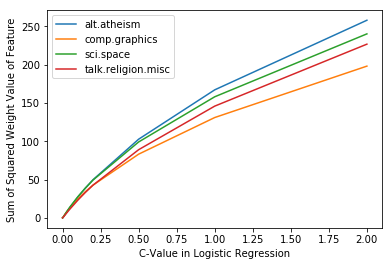

In [12]:
def P3c():
    # // instantiate categories to group by and parameter values to fit data to see optimal parameter values
    categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
    logistic_reg_param_list = [0.00001, 0.0001, 0.0005, 0.001, .005, 0.01, 0.02, 0.03, 0.04,  0.05, 0.1,  0.15, 0.2, 
                     0.5,  1, 2]
    
    # // see 2 for info on CountVectorizer
    vectorizer = CountVectorizer()
    fit_vectorizer = vectorizer.fit_transform(train_data)
    
    # // instantiate lists to append data for plots
    lr_c_value_list = []
    lr_feature_0 = []
    lr_feature_1 = []
    lr_feature_2 = []
    lr_feature_3 = []
    
    print "  {:<18} {:<20} {:<20} {:<20} {:<20}".format("C", categories[0], categories[1], categories[2], categories[3])
    
    # // loop through each parameter and fit LogisticRegression w/ penalty='l2' and fit vectorized data
    for i in logistic_reg_param_list:        
        lr = LogisticRegression(penalty='l2', C=i)
        lr.fit(fit_vectorizer, train_labels)
        # // sum each squared coefficient weights
        feature_sum_0 = (lr.coef_[0]**2).sum()
        feature_sum_1 = (lr.coef_[1]**2).sum()
        feature_sum_2 = (lr.coef_[2]**2).sum()
        feature_sum_3 = (lr.coef_[3]**2).sum()
        # // prin the statement to a pretty table
        print "{:<20} {:<20} {:<20} {:<20} {:<20}".format(i, round(feature_sum_0, 3), round(feature_sum_1, 3), round(feature_sum_2, 3), round(feature_sum_3, 3))
        
        # // append to instantiated lists for plot later
        lr_c_value_list.append(i)
        lr_feature_0.append(feature_sum_0)
        lr_feature_1.append(feature_sum_1)
        lr_feature_2.append(feature_sum_2)
        lr_feature_3.append(feature_sum_3)
    
    # // instantiated plots
    fig = plt.figure()
    plt.plot(lr_c_value_list, lr_feature_0, label=categories[0])
    plt.plot(lr_c_value_list, lr_feature_1, label=categories[1])
    plt.plot(lr_c_value_list, lr_feature_2, label=categories[2])
    plt.plot(lr_c_value_list, lr_feature_3, label=categories[3])
    plt.xlabel('C-Value in Logistic Regression')
    plt.ylabel('Sum of Squared Weight Value of Feature')
    plt.legend()

# // run def: P3_f1_scores()
# // Input : nothing
# // Output: String print of block text from to answer the prompt 3c specifically f1 data
P3c()

QUESTION 3c: Briefly explain the relationship between the sum and the value of C.

ANSWER 3c: The relationship between the sum and the value of C appears to be a logarithmic function (Increasing at a decreasing rate). According to the scikit documents: C is the Inverse of regularization strength meaning the larger the C is the more penalty on the size of coefficients (or trying to prevent overfitting) which is a variance issue which logistic regression is more prone to.

(4) Train a logistic regression model. Find the 5 features with the largest weights for each label -- 20 features in total. Create a table with 20 rows and 4 columns that shows the weight for each of these features for each of the labels. Create the table again with bigram features. Any surprising features in this table?

In [25]:
def P4():
    ### STUDENT START ###
    # // category list for column header print
    categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
    
    # // see 2 for info on CountVectorizer and fits
    vectorizer = CountVectorizer()
    fit_vectorizer = vectorizer.fit_transform(train_data)
    word_strings = vectorizer.get_feature_names()
    lr = LogisticRegression(penalty='l2', C=0.2)
    lr.fit(fit_vectorizer, train_labels)
    
    print "***** MONOGRAM *****"
    print "{:<20} {:<20} {:<20} {:<20} {:<20}".format("FEATURE", categories[0], categories[1], categories[2], categories[3])
    
    # // loop through monogram strings (one word)
    monogram_feature_list = []
    for i in range(4):
        temp_list = []
        # // Find the 5 features with the largest weights for each label -- 20 features in total
        index_list = np.argsort(lr.coef_[i])[-5:]  
        # // reverse the order for largest weights first
        index_list = index_list[::-1]
        # // for each word print the wights of all the categories in the categories list
        for index in index_list:
            print "{:<20} {:<20} {:<20} {:<20} {:<20}".format(word_strings[index], lr.coef_[0][index], lr.coef_[1][index], lr.coef_[2][index], lr.coef_[3][index])
            monogram_feature_list.append(word_strings[index])
            
    print "***** BIGRAM *****"
    bigram_feature_list = []
    # // see 2 for info on CountVectorizer and fits (two strings instead of 2 characters like in 2)
    vectorizer = CountVectorizer(ngram_range=(2, 2))
    fit_vectorizer = vectorizer.fit_transform(train_data)
    word_strings = vectorizer.get_feature_names()
    lr = LogisticRegression(penalty='l2', C=0.2)
    lr.fit(fit_vectorizer, train_labels)
    print "{:<20} {:<20} {:<20} {:<20} {:<20}".format("FEATURE", categories[0], categories[1], categories[2], categories[3])
    # // loop through bigram strings (two words)
    for i in range(4):
        temp_list = []
        # // Find the 5 features with the largest weights for each label -- 20 features in total
        index_list = np.argsort(lr.coef_[i])[-5:]  
        # // reverse the order for largest weights first
        index_list = index_list[::-1]
        # // for each word print the wights of all the categories in the categories list
        for index in index_list:
            print "{:<20} {:<20} {:<20} {:<20} {:<20}".format(word_strings[index], lr.coef_[0][index], lr.coef_[1][index], lr.coef_[2][index], lr.coef_[3][index])
            bigram_feature_list.append(word_strings[index].split(" ")[0])
            bigram_feature_list.append(word_strings[index].split(" ")[1])

    return monogram_feature_list, bigram_feature_list
    ### STUDENT END ###
    
    
# // run def: P4()
# // Input : nothing
# // Output: list: monogram_feature_list - list of monogram words with top weighted values
# // Output: list: bigram_feature_list - list of bigram words with top weighted values
# // output used to figure out how many monogram words are inside the bigram strings
monogram_feature_list, bigram_feature_list = P4()

***** MONOGRAM *****
FEATURE              alt.atheism          comp.graphics        sci.space            talk.religion.misc  
bobby                0.619523408421       -0.150930652214      -0.216393613924      -0.293047145095     
atheism              0.615495239661       -0.267551865761      -0.266374205081      -0.312568405026     
religion             0.615450217389       -0.381247110509      -0.499950142601      -0.0196986575943    
atheists             0.605652617036       -0.0869883882871     -0.202595009201      -0.42064308156      
islam                0.528230257806       -0.0939392372616     -0.212968994504      -0.214881346341     
graphics             -0.503219446745      1.25511766301        -0.829109471192      -0.471225884573     
image                -0.341873198825      0.833474234669       -0.487668518158      -0.280144165629     
file                 -0.213917995925      0.808478499072       -0.528662186852      -0.372622061757     
3d                   -0.2320639293

In [26]:
# // instantiate number of overlap of monogram words inside bigram words lists
number_in_bigram = 0
for string in monogram_feature_list:
    # // if monogram word inside of a bigram list then add one
    if string in bigram_feature_list:
        number_in_bigram += 1

print "Out of the 40 words in the bigram list, there are only {} / 20 of the monogram list is in the 20 bigram words".format(number_in_bigram)

Out of the 40 words in the bigram list, there are only 3 / 20 of the monogram list is in the 20 bigram words


Question 4: Create the table again with bigram features. Any surprising features in this table?

ANSWER 4: The words that are inside of the bigram (logistic regression coefficient weights) list contains less than half of the heavily weighted (logistic regression coefficients weights) for the monogram word list. Not surprisingly, there are some common phrases that are in the top 5 list for multiple feature names.

(5) Try to improve the logistic regression classifier by passing a custom preprocessor to CountVectorizer. The preprocessing function runs on the raw text, before it is split into words by the tokenizer. Your preprocessor should try to normalize the input in various ways to improve generalization. For example, try lowercasing everything, replacing sequences of numbers with a single token, removing various other non-letter characters, and shortening long words. If you're not already familiar with regular expressions for manipulating strings, see https://docs.python.org/2/library/re.html, and re.sub() in particular. With your new preprocessor, how much did you reduce the size of the dictionary?

For reference, I was able to improve dev F1 by 2 points.

In [15]:
# // do no preprocessing
def empty_preprocessor(s):
   return s

# // better_preprocessor(s):
# // inputes text block from raw data set used in CountVectorizer() class
def better_preprocessor(s):
    
    ### STUDENT START ###
    s = s.lower()
    # remove digits from string
    s= re.sub(r'[0-9]+', '', s)
    # remove underscores from word
    s = re.sub(r"_+"," ", s)
    # remove words of length 3 or less
    s = re.sub(r'\b\w{1,3}\b', '', s)       
    return s
    ### STUDENT END ###

    
def P5():
    
    ### STUDENT START ###
    
    # // look at 2 for explanation of CountVectorizer and fitting
    # // this specific one preprocesses data with above function (better_preprocessor()) to try and improve
    # f1_score of fitted prediction
    vectorizer = CountVectorizer(preprocessor=better_preprocessor)
    fit_vectorizer = vectorizer.fit_transform(train_data)
    dev_vectorizer = vectorizer.transform(dev_data)
    word_strings = vectorizer.get_feature_names()

    # // fit LogisticRegression w/ penalty='l2' and parameter found in P3() parameter optimizing
    lr = LogisticRegression(penalty='l2', C=0.2)
    lr.fit(fit_vectorizer, train_labels)
    # // predict the text category
    lr_prediction = lr.predict(dev_vectorizer)
    # // fin f1_score for the text category prediction
    lr_f1_metric = metrics.f1_score(dev_labels, lr_prediction, average='macro')  * 100
    
    # // repeat the above with no preprocessing
    vectorizer_empty = CountVectorizer(preprocessor=empty_preprocessor)
    fit_vectorizer_empty = vectorizer_empty.fit_transform(train_data)
    dev_vectorizer_empty = vectorizer_empty.transform(dev_data)
    lr_empty = LogisticRegression(penalty='l2', C=0.2)
    lr_empty.fit(fit_vectorizer_empty, train_labels)
    lr_prediction_empty = lr_empty.predict(dev_vectorizer_empty)
    lr_f1_metric_empty = metrics.f1_score(dev_labels, lr_prediction_empty, average='macro')  * 100
    
    # // improvement of preprocessing vs no preprocessing    
    improvement = lr_f1_metric - lr_f1_metric_empty
    reduction = fit_vectorizer_empty.shape[1] - fit_vectorizer.shape[1]
    
    print "With the better_preprocessor(s) function, I was able to get {} points larger".format(round(improvement, 3))    
    print "The size  of the dictionary went from {} to {} for a reduction of {} words in the dictionary".format(fit_vectorizer_empty.shape[1], fit_vectorizer.shape[1], reduction)

    ### STUDENT END ###
    
# // run def: P5()
# // Input : nothing
# // Output: string block to show difference between f1_scores of preprocessing text and not preprocessing text
# // with the size of vocabulary reduction when preprocessing
P5()

With the better_preprocessor(s) function, I was able to get 2.268 points larger
The size  of the dictionary went from 33291 to 22124 for a reduction of 11167 words in the dictionary


(6) The idea of regularization is to avoid learning very large weights (which are likely to fit the training data, but not generalize well) by adding a penalty to the total size of the learned weights. That is, logistic regression seeks the set of weights that minimizes errors in the training data AND has a small size. The default regularization, L2, computes this size as the sum of the squared weights (see P3, above). L1 regularization computes this size as the sum of the absolute values of the weights. The result is that whereas L2 regularization makes all the weights relatively small, L1 regularization drives lots of the weights to 0, effectively removing unimportant features.

Train a logistic regression model using a "l1" penalty. Output the number of learned weights that are not equal to zero. How does this compare to the number of non-zero weights you get with "l2"? Now, reduce the size of the vocabulary by keeping only those features that have at least one non-zero weight and retrain a model using "l2".

Make a plot showing accuracy of the re-trained model vs. the vocabulary size you get when pruning unused features by adjusting the C parameter.

Note: The gradient descent code that trains the logistic regression model sometimes has trouble converging with extreme settings of the C parameter. Relax the convergence criteria by setting tol=.01 (the default is .0001).

The l2 penalty LogisticRegression yielded: 107516 nonzero learned weights
The l1 penalty LogisticRegression yielded: 1743 nonzero learned weights
The l2 penalty LogisticRegression had 105773 more nonzero learned weights than the l1 penalty LogisticRegression


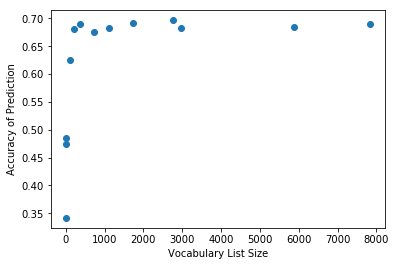

In [16]:
def P6():
    # Keep this random seed here to make comparison easier.
    np.random.seed(0)

    ### STUDENT START ###
    
    # // see 2 for explanation on CountVectorizer() and fitting
    vectorizer = CountVectorizer()
    fit_data = vectorizer.fit_transform(train_data)
    
    # // try to use LogisticRegression() w/ penalty='l1' to see difference b/w penalty='l1' and penalty='l2'
    lr_l1 = LogisticRegression(penalty='l1')
    lr_l1.fit(fit_data, train_labels)
    l1_weight_above_0 = 0
    # // loop through the coefficients
    for category in lr_l1.coef_:
        # // loop through each weight in each category
        for weight in category:
            # // if the weight is above 0 add 1 to the count of above 1
            if weight != 0.0:
                l1_weight_above_0 += 1
    
    # // similar to above but with penalty='l2' instead of penalty='l1'
    lr_l2 = LogisticRegression(penalty='l2')
    lr_l2.fit(fit_data, train_labels)
    l2_weight_above_0 = 0
    for category in lr_l2.coef_:
        for weight in category:
            if weight != 0.0:
                l2_weight_above_0 += 1
    
    print "The l2 penalty LogisticRegression yielded: {} nonzero learned weights".format(l2_weight_above_0)
    print "The l1 penalty LogisticRegression yielded: {} nonzero learned weights".format(l1_weight_above_0)
    print "The l2 penalty LogisticRegression had {} more nonzero learned weights than the l1 penalty LogisticRegression".format(l2_weight_above_0 - l1_weight_above_0)
    
    c_list = [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.5, 1.0, 2.5, 5.0, 10.0, 50.0, 100.0]
    accuracy_list = []
    vocab_amount_list = []
    # // loop through each parameter and fit LogisticRegression penalty='l1'
    for c in c_list:
        lr_l1_final = LogisticRegression(penalty='l1', C=c, tol=.01)
        lr_l1_final.fit(fit_data, train_labels)
        full_index_list = []
        # // loop through the coefficients
        for category in lr_l1_final.coef_:
            index = 0
            # // loop through all the weights and if the weight is above 0 add 1 to the append the index to a list for 
            # // later manipulation
            for weight in category:
                if weight != 0.0:
                    full_index_list.append(index)
                index += 1
    
        # // find the unique vocabulary
        vocab_index = np.unique(full_index_list)
        
        l2_vocab = []
        for index in vocab_index:
            l2_vocab.append(vectorizer.get_feature_names()[index])
        
        # // fit the LogisticRegression penalty='l2' model with unique vocabulary discovered with the LogisticRegression 
        # // penalty='l1' in order to see what happens when you use penalty 'l1' data (that has been filtered more)
        vectorizer_final = CountVectorizer(vocabulary=l2_vocab)
        l2_fit_data = vectorizer_final.fit_transform(train_data)
        final_dev_data = vectorizer_final.transform(dev_data)
        
        # // take fitted data and predict dev set for accuracy prediciton
        lr_l2_final = LogisticRegression(penalty='l2', C = c, tol=.01)
        lr_l2_final.fit(l2_fit_data, train_labels)
        lr_l2_final_accuracy = lr_l2_final.score(final_dev_data, dev_labels)
        
        # // append accuracy value to a list to plot against varying vocabulary list size effects accuracy of predicition
        # // vocabulary list changes come from varying the C parameter (see above answers on explanation of C parameter)
        accuracy_list.append(lr_l2_final_accuracy)
        vocab_amount_list.append(len(vocab_index))
    
    # // I know the prompt said: accuracy of the re-trained model vs. the vocabulary size
    # //I instead did: the vocabulary size vs. accuracy of the re-trained model (which made more sense to me)
    plt.plot(vocab_amount_list, accuracy_list, 'o')
    plt.xlabel('Vocabulary List Size')
    plt.ylabel('Accuracy of Prediction')

    return 
    ### STUDENT END ###
    
# // run def: P6()
# // Input : nothing
# // Output: string block to show effects of vocabulary size on f1_scores of prediction 
P6()

(7) Use the TfidfVectorizer -- how is this different from the CountVectorizer? Train a logistic regression model with C=100.

Make predictions on the dev data and show the top 3 documents where the ratio R is largest, where R is:

maximum predicted probability / predicted probability of the correct label

What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

In [17]:
def P7():
    ### STUDENT START ###
    
    # // converterted data of raw documents to a matrix of TF-IDF features (normalizes its results)
    vectorizer = TfidfVectorizer()
    # // fit and transform data for model use later
    fit_data = vectorizer.fit_transform(train_data)
    dev_vectorizer = vectorizer.transform(dev_data)
    
    # // use LogisticRegression penalty='l2' for prediction
    lr_l2 = LogisticRegression(penalty='l2', C=100)
    lr_l2.fit(fit_data, train_labels)
    # // predict the categories
    lr_l1_prediction = lr_l2.predict(dev_vectorizer)  
    
    # // using the above prompt: R is: maximum predicted probability / predicted probability of the correct label
    proba = lr_l2.predict_proba(dev_vectorizer)
    max_proba = proba.max(axis=1)
    R = []
    # / grab R values for each value in the dev set (prediction data set)
    for i in range(0, len(dev_labels)):
        R.append(max_proba[i] / proba[i][dev_labels[i]])
      
    # // sort by largest R cvalue first and print actual category, predicted value, text, and R value
    for index in reversed(np.argsort(R)[-3:] ):
        print "*************************************"
        print "Document Number: {}".format(index + 1)
        print "R -Ratio: {}".format(round(R[index], 3))
        print "Actual Category: {}".format(categories[dev_labels[index]])
        print "Predicted Category: {}".format(categories[lr_l1_prediction[index]])
        print "\n"
        print "Document Text:"
        print dev_data[index]
        print "*************************************"
        print "\n"
            
    ## STUDENT END ###
    
# // run def: P7()
# // Input : nothing
# // Output: string block to show actual category, predicted value, text, and R value
P7()

*************************************
Document Number: 216
R -Ratio: 929.358
Actual Category: talk.religion.misc
Predicted Category: comp.graphics


Document Text:
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) errors
have been corrected. This release includes a simplified Joseph Smith Story,
testimonies of the three and eight witnesses, and a "Words-to-Know"
glossary.

As with the previous announcement, readers are reminded that this is a
not-for-profit endeavor. This is a copyrighted work, but people are welcome
to make *verbatim* copies for personal use. People can recuperate the
actual costs of printing (paper, copy center charges), but may not charge
anything for t

QUESTION 7a: How is this different from the CountVectorizer?

ANSWER 7a: The TfidfVectorizer() is different from CountVectorizer() because it normalizes words that are comman in most articles (lowers the weight). Therefore if there are words only in one category and another file references the vocab then it will heavily favor a prediciton where the rarer words are present in.

QUESTION 7b: What kinds of mistakes is the model making? Suggest a way to address one particular issue that you see.

ANSWER 7b:  The problem is the use of detailed information in other categories hurt the prediction. The top two R ratio files are not related to science or technolofy, but mention file names, detail directories, emails, websites, underscores, data types, email, internet and ftp (file transfer protocol). This lingo is most associated with science and technology which makes sense why the prediciton is widely inaccurate (with high R ratios). The third R ratio document confuses religion with atheism. These categories are very close and both topics mention a lot of death and "children" is often used in explaining religion i.e children of god.

Keywords heavily associated with other categories really effect prediction and smaller documents with less information are harder to classify than longer documents.

Suggestion to improve issue: 

1) Use preprocessing to eliminate strange words

2) Remove very common words to lower importance of nonexistant words

3) remove words used in less than n amount of examples

(8) EXTRA CREDIT

Try implementing one of your ideas based on your error analysis. Use logistic regression as your underlying model.

In [18]:
def better_preprocessor(s):
    
    ### STUDENT START ###
    s = s.lower()
    # remove digits from string
    s= re.sub(r'[0-9]+', '', s)    
    return s
    ### STUDENT END ###

def EC():
    categories = ['alt.atheism', 'comp.graphics', 'sci.space', 'talk.religion.misc']
    vectorizer = TfidfVectorizer()
    fit_data = vectorizer.fit_transform(train_data)
    fit_vectorizer_dev = vectorizer.transform(dev_data)
    
    lr_ec = LogisticRegression(penalty='l2')
    lr_ec.fit(fit_data, train_labels)
    lr_ec_prediction = lr_ec.predict(fit_vectorizer_dev)
    lr_ec_metric = metrics.f1_score(dev_labels, lr_ec_prediction, average='micro')  * 100
    print "Regular model philosophy yields a f1 metric of: {}".format(lr_ec_metric)
    
    # // https://en.wikipedia.org/wiki/Most_common_words_in_English and additional strange words that 
    # // could show up in regular talk i.e. 'ftp', 'email', 'ASCII', 'LaTeX', 'RTF', 'Microsoft', 'Word', 'Apple' etc
    # // this will reduce confusion from words that are common in any dialougue as well with technical words 
    # // that can be used successfully by anyone
    my_stop_words = ['time', 'person', 'year', 'way', 'day', 'thing', 'man', 'world', 'life', 
                     'hand', 'part', 'child', 'eye', 'woman', 'place', 'work', 'week', 'case', 
                     'point', 'government', 'company', 'number', 'group', 'problem', 'fact', 
                     'be', 'have', 'do', 'say', 'get', 'make', 'go', 'know', 'take', 'see', 
                     'come', 'think', 'look', 'want', 'give', 'use', 'find', 'tell', 'ask', 
                     'work', 'seem', 'feel', 'try', 'leave', 'call', 'good', 'new', 'first', 
                     'last', 'long', 'great', 'little', 'own', 'other', 'old', 'right', 'big', 
                     'high', 'different', 'small', 'large', 'next', 'early', 'young', 'important', 
                     'few', 'public', 'bad', 'same', 'able', 'to', 'of', 'in', 'for', 'on', 'with', 
                     'at', 'by', 'from', 'up', 'about', 'into', 'over', 'after', 'the', 'and', 
                     'a', 'that', 'I', 'it', 'not', 'he', 'as', 'you', 'this', 'but', 'his', 'they', 
                     'her', 'she', 'or', 'an', 'will', 'my', 'one', 'all', 'would', 'there', 'their',
                    'ftp', 'email', 'ASCII', 'LaTeX', 'RTF', 'Microsoft', 'Word', 'Apple', 'internet',
                    'online', 'version', 'first', 'second', 'third', 'fourth', 'fifth', 'sixth',
                    'seventh', 'eighth', 'nineth', 'tenth', 'one', 'two', 'three', 'four', 'five', 'six',
                    'seven', 'eight', 'nine', 'ten']

    # // using TfidfVectorizer with a no use word list and lowercase words and better_preprocessor that removes digits
    prune_TFid = TfidfVectorizer(min_df=2, stop_words=set(my_stop_words), lowercase=False, preprocessor=better_preprocessor)
    # // fit and fit transform data for fitting and prediction later
    fit_prune_TFid = prune_TFid.fit_transform(train_data)
    fit_prune_dev_TFid = prune_TFid.transform(dev_data)
    lr_ec_update_TFid = LogisticRegression(penalty='l2')
    lr_ec_update_TFid.fit(fit_prune_TFid, train_labels)
    lr_ec_update_prediction_TFid = lr_ec_update_TFid.predict(fit_prune_dev_TFid)
    # // run the metric
    lr_ec_update_metric_TFid = metrics.f1_score(dev_labels, lr_ec_update_prediction_TFid, average='micro')  * 100
    print "Updated model philosophy yields a f1 metric of: {}".format(lr_ec_update_metric_TFid)
    
    # // run the same R-ratio code lines to show reduction of R from above
    proba = lr_ec_update_TFid.predict_proba(fit_prune_dev_TFid)
    max_proba = proba.max(axis=1)
    R = []
    # / grab R values for each value in the dev set (prediction data set)
    for i in range(0, len(dev_labels)):
        R.append(max_proba[i] / proba[i][dev_labels[i]])
      
    # // sort by largest R cvalue first and print actual category, predicted value, text, and R value
    for index in reversed(np.argsort(R)[-3:] ):
        print "*************************************"
        print "Document Number: {}".format(index + 1)
        print "R -Ratio: {}".format(round(R[index], 3))
        print "Actual Category: {}".format(categories[dev_labels[index]])
        print "Predicted Category: {}".format(categories[lr_ec_update_prediction_TFid[index]])
        print "\n"
        print "Document Text:"
        print dev_data[index]
        print "*************************************"
        print "\n"
    
    
EC()

Regular model philosophy yields a f1 metric of: 72.0414201183
Updated model philosophy yields a f1 metric of: 75.1479289941
*************************************
Document Number: 666
R -Ratio: 7.527
Actual Category: talk.religion.misc
Predicted Category: comp.graphics


Document Text:
Can anyone provide me a ftp site where I can obtain a online version
of the Book of Mormon. Please email the internet address if possible.
*************************************


*************************************
Document Number: 216
R -Ratio: 7.047
Actual Category: talk.religion.misc
Predicted Category: comp.graphics


Document Text:
I am pleased to announce that a *revised version* of _The Easy-to-Read Book
of Mormon_ (former title: _Mormon's Book_) by Lynn Matthews Anderson is now
available through anonymous ftp (see information below). In addition to the
change in title, the revised ETR BOM has been shortened by several pages
(eliminating many extraneous "that's" and "of's"), and many (minor) erro

Final Note:

Looking at the above data, there is improved performance (f_1 metric) and lowered R ratio down from in the hundreds to in the single digits